In [ ]:
from google.colab import drive

drive.mount("/content/gdrive")


!unzip '/content/gdrive/MyDrive/2.zip'



import os
a = '/content/1/test/aeroplane'
path, dirs, files = next(os.walk(a))
file_count = len(files)
print(file_count)

import time 
import torch, os
import torchvision
import torchvision.transforms as transforms
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import random

transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize(mean=[0.5,0.5,0.5], std=[0.5, 0.5, 0.5])])


train_data_dir = "/content/1/train"

val_data_dir = "/content/1/val"
test_data_dir = "/content/1/test"
# take the dataset from the location nad transform it 
trainset = torchvision.datasets.ImageFolder(root=train_data_dir, transform=transform)
#divide the data into batches with batch_size=4
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=1)
print(len(trainset))

valnset = torchvision.datasets.ImageFolder(root= val_data_dir, transform=transform)
valloader = torch.utils.data.DataLoader(valnset, batch_size=4,
                                          shuffle=True, num_workers=1)

testset = torchvision.datasets.ImageFolder(root= test_data_dir , transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=1)




import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models

# <<<<<<<<<<<<<<<<<<<<< EDIT THE MODEL DEFINITION >>>>>>>>>>>>>>>>>>>>>>>>>>
# Try experimenting by changing the following:
# 1. number of feature maps in conv layer
# 2. Number of conv layers
# 3. Kernel size
# etc etc.,

num_epochs = 100     # desired number of training epochs.
learning_rate = 0.001   

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        

        self.fc1 = nn.Linear(in_features=256, out_features=256)
        self.fc2 = nn.Linear(in_features=256, out_features=128)
        
        self.fc3 = nn.Linear(in_features=128, out_features=5) 
        
         # 5 is the number of classes here (for batch 3,4,5 out_features is 33)

    def forward(self, x): 

        x = F.relu(self.conv1(x))
        x = self.pool(x)
        
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        
        x = F.relu(self.conv3(x))
        x = self.pool(x)
        
        x = F.avg_pool2d(x, kernel_size=x.shape[2:])
        x = x.view(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        
        
        x = self.fc3(x)
        
        return x  

################### DO NOT EDIT THE BELOW CODE!!! #######################

net = Net()

# transfer the model to GPU
if torch.cuda.is_available():
    net = net.cuda()
# net.load_state_dict(torch.load('/content/gdrive/MyDrive/bestmodel.pth'))

########################################################################
# Define a Loss function and optimizer
# ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
# Let's use a Classification Cross-Entropy loss and SGD with momentum.

import torch.optim as optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9, weight_decay=5e-4)

num_params = np.sum([p.nelement() for p in net.parameters()])
print(num_params, ' parameters')

########################################################################
# Train the network
# ^^^^^^^^^^^^^^^^^^^^
start=time.time()
def train(epoch, trainloader, optimizer, criterion,net):
    running_loss = 0.0
    correct=0
    total=0
    for i, data in enumerate(tqdm(trainloader), 0):
        # get the inputs
        inputs, labels = data
        if torch.cuda.is_available():
            inputs, labels = inputs.cuda(), labels.cuda()

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    

    print('epoch %d training loss: %.3f' %
            (epoch + 1, running_loss / (len(trainloader))))
    print('Accuracy of the network on the train images: %f %%' % (
                                    100 * correct / total))
    return (100* correct/total)

    
########################################################################
# Let us look at how the network performs on the test dataset.

def test(testloader, model):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in tqdm(testloader):
            images, labels = data
            if torch.cuda.is_available():
                images, labels = images.cuda(), labels.cuda()        
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    print('Accuracy of the network on the test images: %f %%' % (
                                    100 * correct / total))
    return (100* correct/total)

#########################################################################
# get details of classes and class to index mapping in a directory
def find_classes(dir):
    classes = [d for d in os.listdir(dir) if os.path.isdir(os.path.join(dir, d))]
    classes.sort()
    class_to_idx = {classes[i]: i for i in range(len(classes))}
    return classes, class_to_idx


def classwise_test(testloader, model):
########################################################################
# class-wise accuracy

    classes, _ = find_classes(train_data_dir)
    n_class = len(classes) # number of classes

    class_correct = list(0. for i in range(n_class))
    class_total = list(0. for i in range(n_class))
    with torch.no_grad():
        for data in tqdm(testloader):
            images, labels = data
            if torch.cuda.is_available():
                images, labels = images.cuda(), labels.cuda()        
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            c = (predicted == labels).squeeze()
            for i in range(4):
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1

    for i in range(n_class):
        print('Accuracy of %10s : %2f %%' % (
            classes[i], 100 * class_correct[i] / class_total[i]))

print('Start Training')
os.makedirs('./models', exist_ok=True)
train_accuracies=[]
test_accuracies=[]
val_accuracies=[]

for epoch in range(num_epochs):  # loop over the dataset multiple times
    print('epoch ', epoch + 1)
    train_accuracy=train(epoch, trainloader, optimizer, criterion,net)
    train_accuracies.append(train_accuracy)
    val_accuracy=test(valloader, net)
    val_accuracies.append(val_accuracy)
    # test_accuracy=test(testloader, net)
    # test_accuracies.append(test_accuracy)
#     classwise_test(valloader, net)
    # save model checkpoint 
    torch.save(net.state_dict(), './models/model'+str(epoch)+'.pth')      

print('performing test')
test_accuracy=test(testloader, net)
classwise_test(testloader, net)

print('Finished Training')

# Saving our trained model
torch.save(net.state_dict(), './models/bestmodelepochs100.pth')
print(len(train_accuracies))
print(len(val_accuracies))
with open(r'trainepochs100.txt', 'w') as fp:
  for item in train_accuracies:
     fp.write("%s\n" % item)
with open(r'valepochs100.txt', 'w') as fp:
  for item in train_accuracies:
     fp.write("%s\n" % item)




Streaming output truncated to the last 5000 lines.
  inflating: 1/train/bird/pipit_s_000221.png  
 extracting: 1/train/bird/passerine_s_001226.png  
 extracting: 1/train/bird/emu_s_001158.png  
 extracting: 1/train/bird/accentor_s_000039.png  
 extracting: 1/train/bird/pipit_s_000029.png  
 extracting: 1/train/bird/ostrich_s_002262.png  
 extracting: 1/train/bird/struthio_camelus_s_000156.png  
  inflating: 1/train/bird/flightless_bird_s_000353.png  
 extracting: 1/train/bird/pipit_s_000443.png  
 extracting: 1/train/bird/ostrich_s_000506.png  
  inflating: 1/train/bird/sparrow_s_000490.png  
  inflating: 1/train/bird/ostrich_s_002057.png  
  inflating: 1/train/bird/meadow_pipit_s_000610.png  
 extracting: 1/train/bird/cassowary_s_001833.png  
 extracting: 1/train/bird/flying_bird_s_000775.png  
  inflating: 1/train/bird/dunnock_s_001078.png  
  inflating: 1/train/bird/emu_s_000258.png  
 extracting: 1/train/bird/dunnock_s_000507.png  
 extracting: 1/train/bird/passerine_s_000671.png  

100%|██████████| 6250/6250 [00:47<00:00, 131.10it/s]


epoch 1 training loss: 1.421
Accuracy of the network on the train images: 33.264000 %


100%|██████████| 625/625 [00:03<00:00, 206.19it/s]


Accuracy of the network on the test images: 46.720000 %
epoch  2


100%|██████████| 6250/6250 [00:38<00:00, 163.10it/s]


epoch 2 training loss: 1.170
Accuracy of the network on the train images: 46.764000 %


100%|██████████| 625/625 [00:02<00:00, 212.35it/s]


Accuracy of the network on the test images: 51.200000 %
epoch  3


100%|██████████| 6250/6250 [00:38<00:00, 160.74it/s]


epoch 3 training loss: 1.104
Accuracy of the network on the train images: 50.452000 %


100%|██████████| 625/625 [00:03<00:00, 205.47it/s]


Accuracy of the network on the test images: 53.120000 %
epoch  4


100%|██████████| 6250/6250 [00:38<00:00, 161.62it/s]


epoch 4 training loss: 1.060
Accuracy of the network on the train images: 52.920000 %


100%|██████████| 625/625 [00:03<00:00, 159.44it/s]


Accuracy of the network on the test images: 54.200000 %
epoch  5


100%|██████████| 6250/6250 [00:38<00:00, 161.07it/s]


epoch 5 training loss: 1.021
Accuracy of the network on the train images: 54.856000 %


100%|██████████| 625/625 [00:02<00:00, 208.91it/s]


Accuracy of the network on the test images: 55.000000 %
epoch  6


100%|██████████| 6250/6250 [00:38<00:00, 162.61it/s]


epoch 6 training loss: 0.989
Accuracy of the network on the train images: 56.488000 %


100%|██████████| 625/625 [00:02<00:00, 210.93it/s]


Accuracy of the network on the test images: 56.440000 %
epoch  7


100%|██████████| 6250/6250 [00:38<00:00, 162.73it/s]


epoch 7 training loss: 0.959
Accuracy of the network on the train images: 58.156000 %


100%|██████████| 625/625 [00:03<00:00, 206.79it/s]


Accuracy of the network on the test images: 58.880000 %
epoch  8


100%|██████████| 6250/6250 [00:40<00:00, 155.42it/s]


epoch 8 training loss: 0.924
Accuracy of the network on the train images: 60.216000 %


100%|██████████| 625/625 [00:03<00:00, 203.60it/s]


Accuracy of the network on the test images: 61.120000 %
epoch  9


100%|██████████| 6250/6250 [00:38<00:00, 161.85it/s]


epoch 9 training loss: 0.891
Accuracy of the network on the train images: 62.116000 %


100%|██████████| 625/625 [00:02<00:00, 209.57it/s]


Accuracy of the network on the test images: 63.080000 %
epoch  10


100%|██████████| 6250/6250 [00:38<00:00, 162.60it/s]


epoch 10 training loss: 0.850
Accuracy of the network on the train images: 64.160000 %


100%|██████████| 625/625 [00:02<00:00, 211.07it/s]


Accuracy of the network on the test images: 66.920000 %
epoch  11


100%|██████████| 6250/6250 [00:39<00:00, 157.67it/s]


epoch 11 training loss: 0.815
Accuracy of the network on the train images: 65.996000 %


100%|██████████| 625/625 [00:03<00:00, 206.91it/s]


Accuracy of the network on the test images: 67.160000 %
epoch  12


100%|██████████| 6250/6250 [00:37<00:00, 164.49it/s]


epoch 12 training loss: 0.775
Accuracy of the network on the train images: 67.956000 %


100%|██████████| 625/625 [00:03<00:00, 207.74it/s]


Accuracy of the network on the test images: 67.880000 %
epoch  13


100%|██████████| 6250/6250 [00:38<00:00, 163.51it/s]


epoch 13 training loss: 0.742
Accuracy of the network on the train images: 69.436000 %


100%|██████████| 625/625 [00:02<00:00, 210.85it/s]


Accuracy of the network on the test images: 70.080000 %
epoch  14


100%|██████████| 6250/6250 [00:39<00:00, 158.92it/s]


epoch 14 training loss: 0.712
Accuracy of the network on the train images: 70.904000 %


100%|██████████| 625/625 [00:03<00:00, 204.39it/s]


Accuracy of the network on the test images: 70.640000 %
epoch  15


100%|██████████| 6250/6250 [00:39<00:00, 156.90it/s]


epoch 15 training loss: 0.679
Accuracy of the network on the train images: 72.508000 %


100%|██████████| 625/625 [00:03<00:00, 205.31it/s]


Accuracy of the network on the test images: 71.040000 %
epoch  16


100%|██████████| 6250/6250 [00:38<00:00, 161.91it/s]


epoch 16 training loss: 0.649
Accuracy of the network on the train images: 73.788000 %


100%|██████████| 625/625 [00:03<00:00, 207.49it/s]


Accuracy of the network on the test images: 73.000000 %
epoch  17


100%|██████████| 6250/6250 [00:38<00:00, 162.82it/s]


epoch 17 training loss: 0.619
Accuracy of the network on the train images: 75.436000 %


100%|██████████| 625/625 [00:02<00:00, 210.30it/s]


Accuracy of the network on the test images: 69.560000 %
epoch  18


100%|██████████| 6250/6250 [00:39<00:00, 158.23it/s]


epoch 18 training loss: 0.593
Accuracy of the network on the train images: 76.220000 %


100%|██████████| 625/625 [00:02<00:00, 211.47it/s]


Accuracy of the network on the test images: 75.040000 %
epoch  19


100%|██████████| 6250/6250 [00:38<00:00, 164.05it/s]


epoch 19 training loss: 0.568
Accuracy of the network on the train images: 77.444000 %


100%|██████████| 625/625 [00:02<00:00, 213.82it/s]


Accuracy of the network on the test images: 77.280000 %
epoch  20


100%|██████████| 6250/6250 [00:38<00:00, 164.03it/s]


epoch 20 training loss: 0.544
Accuracy of the network on the train images: 78.636000 %


100%|██████████| 625/625 [00:02<00:00, 213.72it/s]


Accuracy of the network on the test images: 76.040000 %
epoch  21


100%|██████████| 6250/6250 [00:38<00:00, 160.30it/s]


epoch 21 training loss: 0.522
Accuracy of the network on the train images: 79.544000 %


100%|██████████| 625/625 [00:02<00:00, 209.59it/s]


Accuracy of the network on the test images: 73.400000 %
epoch  22


100%|██████████| 6250/6250 [00:38<00:00, 164.17it/s]


epoch 22 training loss: 0.497
Accuracy of the network on the train images: 80.512000 %


100%|██████████| 625/625 [00:02<00:00, 211.61it/s]


Accuracy of the network on the test images: 76.680000 %
epoch  23


100%|██████████| 6250/6250 [00:37<00:00, 164.78it/s]


epoch 23 training loss: 0.478
Accuracy of the network on the train images: 81.228000 %


100%|██████████| 625/625 [00:02<00:00, 216.42it/s]


Accuracy of the network on the test images: 74.760000 %
epoch  24


100%|██████████| 6250/6250 [00:38<00:00, 164.23it/s]


epoch 24 training loss: 0.460
Accuracy of the network on the train images: 81.596000 %


100%|██████████| 625/625 [00:03<00:00, 162.57it/s]


Accuracy of the network on the test images: 78.240000 %
epoch  25


100%|██████████| 6250/6250 [00:37<00:00, 164.81it/s]


epoch 25 training loss: 0.443
Accuracy of the network on the train images: 82.780000 %


100%|██████████| 625/625 [00:02<00:00, 211.07it/s]


Accuracy of the network on the test images: 76.960000 %
epoch  26


100%|██████████| 6250/6250 [00:37<00:00, 164.99it/s]


epoch 26 training loss: 0.426
Accuracy of the network on the train images: 83.408000 %


100%|██████████| 625/625 [00:02<00:00, 211.34it/s]


Accuracy of the network on the test images: 76.600000 %
epoch  27


100%|██████████| 6250/6250 [00:38<00:00, 162.26it/s]


epoch 27 training loss: 0.408
Accuracy of the network on the train images: 84.100000 %


100%|██████████| 625/625 [00:03<00:00, 205.55it/s]


Accuracy of the network on the test images: 78.200000 %
epoch  28


100%|██████████| 6250/6250 [00:39<00:00, 156.74it/s]


epoch 28 training loss: 0.390
Accuracy of the network on the train images: 84.892000 %


100%|██████████| 625/625 [00:02<00:00, 210.48it/s]


Accuracy of the network on the test images: 79.440000 %
epoch  29


100%|██████████| 6250/6250 [00:38<00:00, 163.20it/s]


epoch 29 training loss: 0.371
Accuracy of the network on the train images: 85.632000 %


100%|██████████| 625/625 [00:02<00:00, 208.35it/s]


Accuracy of the network on the test images: 76.640000 %
epoch  30


100%|██████████| 6250/6250 [00:38<00:00, 162.47it/s]


epoch 30 training loss: 0.358
Accuracy of the network on the train images: 86.296000 %


100%|██████████| 625/625 [00:02<00:00, 210.65it/s]


Accuracy of the network on the test images: 80.400000 %
epoch  31


100%|██████████| 6250/6250 [00:39<00:00, 159.35it/s]


epoch 31 training loss: 0.343
Accuracy of the network on the train images: 86.700000 %


100%|██████████| 625/625 [00:02<00:00, 212.59it/s]


Accuracy of the network on the test images: 80.200000 %
epoch  32


100%|██████████| 6250/6250 [00:38<00:00, 163.59it/s]


epoch 32 training loss: 0.329
Accuracy of the network on the train images: 87.380000 %


100%|██████████| 625/625 [00:02<00:00, 212.47it/s]


Accuracy of the network on the test images: 80.120000 %
epoch  33


100%|██████████| 6250/6250 [00:37<00:00, 164.50it/s]


epoch 33 training loss: 0.317
Accuracy of the network on the train images: 87.632000 %


100%|██████████| 625/625 [00:02<00:00, 209.40it/s]


Accuracy of the network on the test images: 79.880000 %
epoch  34


100%|██████████| 6250/6250 [00:39<00:00, 156.87it/s]


epoch 34 training loss: 0.302
Accuracy of the network on the train images: 88.592000 %


100%|██████████| 625/625 [00:03<00:00, 206.23it/s]


Accuracy of the network on the test images: 80.800000 %
epoch  35


100%|██████████| 6250/6250 [00:38<00:00, 162.27it/s]


epoch 35 training loss: 0.288
Accuracy of the network on the train images: 89.032000 %


100%|██████████| 625/625 [00:03<00:00, 207.82it/s]


Accuracy of the network on the test images: 82.440000 %
epoch  36


100%|██████████| 6250/6250 [00:38<00:00, 161.34it/s]


epoch 36 training loss: 0.280
Accuracy of the network on the train images: 89.168000 %


100%|██████████| 625/625 [00:03<00:00, 207.58it/s]


Accuracy of the network on the test images: 79.200000 %
epoch  37


100%|██████████| 6250/6250 [00:39<00:00, 159.21it/s]


epoch 37 training loss: 0.265
Accuracy of the network on the train images: 89.944000 %


100%|██████████| 625/625 [00:03<00:00, 205.23it/s]


Accuracy of the network on the test images: 81.840000 %
epoch  38


100%|██████████| 6250/6250 [00:39<00:00, 156.93it/s]


epoch 38 training loss: 0.257
Accuracy of the network on the train images: 90.336000 %


100%|██████████| 625/625 [00:03<00:00, 206.71it/s]


Accuracy of the network on the test images: 82.000000 %
epoch  39


100%|██████████| 6250/6250 [00:38<00:00, 162.34it/s]


epoch 39 training loss: 0.244
Accuracy of the network on the train images: 90.620000 %


100%|██████████| 625/625 [00:03<00:00, 207.72it/s]


Accuracy of the network on the test images: 81.440000 %
epoch  40


100%|██████████| 6250/6250 [00:38<00:00, 161.66it/s]


epoch 40 training loss: 0.231
Accuracy of the network on the train images: 91.140000 %


100%|██████████| 625/625 [00:03<00:00, 203.87it/s]


Accuracy of the network on the test images: 81.640000 %
epoch  41


100%|██████████| 6250/6250 [00:40<00:00, 154.98it/s]


epoch 41 training loss: 0.219
Accuracy of the network on the train images: 91.616000 %


100%|██████████| 625/625 [00:03<00:00, 207.81it/s]


Accuracy of the network on the test images: 81.200000 %
epoch  42


100%|██████████| 6250/6250 [00:38<00:00, 160.77it/s]


epoch 42 training loss: 0.207
Accuracy of the network on the train images: 92.160000 %


100%|██████████| 625/625 [00:03<00:00, 207.04it/s]


Accuracy of the network on the test images: 81.200000 %
epoch  43


100%|██████████| 6250/6250 [00:38<00:00, 160.51it/s]


epoch 43 training loss: 0.196
Accuracy of the network on the train images: 92.608000 %


100%|██████████| 625/625 [00:03<00:00, 207.42it/s]


Accuracy of the network on the test images: 81.200000 %
epoch  44


100%|██████████| 6250/6250 [00:39<00:00, 157.04it/s]


epoch 44 training loss: 0.191
Accuracy of the network on the train images: 92.784000 %


100%|██████████| 625/625 [00:03<00:00, 206.12it/s]


Accuracy of the network on the test images: 80.440000 %
epoch  45


100%|██████████| 6250/6250 [00:38<00:00, 161.17it/s]


epoch 45 training loss: 0.184
Accuracy of the network on the train images: 93.248000 %


100%|██████████| 625/625 [00:02<00:00, 211.00it/s]


Accuracy of the network on the test images: 81.800000 %
epoch  46


100%|██████████| 6250/6250 [00:38<00:00, 163.23it/s]


epoch 46 training loss: 0.175
Accuracy of the network on the train images: 93.504000 %


100%|██████████| 625/625 [00:02<00:00, 209.54it/s]


Accuracy of the network on the test images: 82.920000 %
epoch  47


100%|██████████| 6250/6250 [00:38<00:00, 160.53it/s]


epoch 47 training loss: 0.171
Accuracy of the network on the train images: 93.496000 %


100%|██████████| 625/625 [00:03<00:00, 207.60it/s]


Accuracy of the network on the test images: 81.560000 %
epoch  48


100%|██████████| 6250/6250 [00:40<00:00, 154.91it/s]


epoch 48 training loss: 0.158
Accuracy of the network on the train images: 94.032000 %


100%|██████████| 625/625 [00:03<00:00, 203.47it/s]


Accuracy of the network on the test images: 82.680000 %
epoch  49


100%|██████████| 6250/6250 [00:39<00:00, 158.76it/s]


epoch 49 training loss: 0.151
Accuracy of the network on the train images: 94.548000 %


100%|██████████| 625/625 [00:03<00:00, 203.88it/s]


Accuracy of the network on the test images: 82.000000 %
epoch  50


100%|██████████| 6250/6250 [00:39<00:00, 160.03it/s]


epoch 50 training loss: 0.139
Accuracy of the network on the train images: 94.920000 %


100%|██████████| 625/625 [00:03<00:00, 207.11it/s]


Accuracy of the network on the test images: 81.120000 %
epoch  51


100%|██████████| 6250/6250 [00:40<00:00, 155.49it/s]


epoch 51 training loss: 0.145
Accuracy of the network on the train images: 94.756000 %


100%|██████████| 625/625 [00:03<00:00, 208.19it/s]


Accuracy of the network on the test images: 80.800000 %
epoch  52


100%|██████████| 6250/6250 [00:38<00:00, 163.32it/s]


epoch 52 training loss: 0.130
Accuracy of the network on the train images: 95.312000 %


100%|██████████| 625/625 [00:02<00:00, 211.46it/s]


Accuracy of the network on the test images: 80.280000 %
epoch  53


100%|██████████| 6250/6250 [00:38<00:00, 163.91it/s]


epoch 53 training loss: 0.117
Accuracy of the network on the train images: 95.860000 %


100%|██████████| 625/625 [00:02<00:00, 211.52it/s]


Accuracy of the network on the test images: 82.600000 %
epoch  54


100%|██████████| 6250/6250 [00:39<00:00, 158.27it/s]


epoch 54 training loss: 0.125
Accuracy of the network on the train images: 95.388000 %


100%|██████████| 625/625 [00:02<00:00, 211.63it/s]


Accuracy of the network on the test images: 83.040000 %
epoch  55


100%|██████████| 6250/6250 [00:38<00:00, 162.00it/s]


epoch 55 training loss: 0.117
Accuracy of the network on the train images: 95.848000 %


100%|██████████| 625/625 [00:02<00:00, 211.15it/s]


Accuracy of the network on the test images: 81.560000 %
epoch  56


100%|██████████| 6250/6250 [00:38<00:00, 161.94it/s]


epoch 56 training loss: 0.123
Accuracy of the network on the train images: 95.548000 %


100%|██████████| 625/625 [00:02<00:00, 212.57it/s]


Accuracy of the network on the test images: 82.240000 %
epoch  57


100%|██████████| 6250/6250 [00:39<00:00, 159.16it/s]


epoch 57 training loss: 0.116
Accuracy of the network on the train images: 95.828000 %


100%|██████████| 625/625 [00:03<00:00, 183.47it/s]


Accuracy of the network on the test images: 80.560000 %
epoch  58


100%|██████████| 6250/6250 [00:38<00:00, 162.13it/s]


epoch 58 training loss: 0.110
Accuracy of the network on the train images: 95.992000 %


100%|██████████| 625/625 [00:02<00:00, 211.96it/s]


Accuracy of the network on the test images: 80.560000 %
epoch  59


100%|██████████| 6250/6250 [00:38<00:00, 162.56it/s]


epoch 59 training loss: 0.105
Accuracy of the network on the train images: 96.328000 %


100%|██████████| 625/625 [00:02<00:00, 209.43it/s]


Accuracy of the network on the test images: 79.960000 %
epoch  60


100%|██████████| 6250/6250 [00:38<00:00, 163.15it/s]


epoch 60 training loss: 0.107
Accuracy of the network on the train images: 96.148000 %


100%|██████████| 625/625 [00:02<00:00, 208.97it/s]


Accuracy of the network on the test images: 79.600000 %
epoch  61


100%|██████████| 6250/6250 [00:39<00:00, 158.37it/s]


epoch 61 training loss: 0.096
Accuracy of the network on the train images: 96.572000 %


100%|██████████| 625/625 [00:02<00:00, 213.73it/s]


Accuracy of the network on the test images: 81.840000 %
epoch  62


100%|██████████| 6250/6250 [00:38<00:00, 163.70it/s]


epoch 62 training loss: 0.096
Accuracy of the network on the train images: 96.564000 %


100%|██████████| 625/625 [00:02<00:00, 208.65it/s]


Accuracy of the network on the test images: 81.760000 %
epoch  63


100%|██████████| 6250/6250 [00:38<00:00, 161.67it/s]


epoch 63 training loss: 0.101
Accuracy of the network on the train images: 96.424000 %


100%|██████████| 625/625 [00:03<00:00, 208.14it/s]


Accuracy of the network on the test images: 80.520000 %
epoch  64


100%|██████████| 6250/6250 [00:39<00:00, 158.26it/s]


epoch 64 training loss: 0.079
Accuracy of the network on the train images: 97.292000 %


100%|██████████| 625/625 [00:02<00:00, 210.69it/s]


Accuracy of the network on the test images: 82.680000 %
epoch  65


100%|██████████| 6250/6250 [00:38<00:00, 164.32it/s]


epoch 65 training loss: 0.102
Accuracy of the network on the train images: 96.420000 %


100%|██████████| 625/625 [00:02<00:00, 212.50it/s]


Accuracy of the network on the test images: 82.240000 %
epoch  66


100%|██████████| 6250/6250 [00:37<00:00, 164.82it/s]


epoch 66 training loss: 0.081
Accuracy of the network on the train images: 97.276000 %


100%|██████████| 625/625 [00:03<00:00, 208.28it/s]


Accuracy of the network on the test images: 82.480000 %
epoch  67


100%|██████████| 6250/6250 [00:39<00:00, 159.41it/s]


epoch 67 training loss: 0.080
Accuracy of the network on the train images: 97.280000 %


100%|██████████| 625/625 [00:02<00:00, 210.28it/s]


Accuracy of the network on the test images: 81.120000 %
epoch  68


100%|██████████| 6250/6250 [00:38<00:00, 163.96it/s]


epoch 68 training loss: 0.079
Accuracy of the network on the train images: 97.408000 %


100%|██████████| 625/625 [00:02<00:00, 209.62it/s]


Accuracy of the network on the test images: 81.240000 %
epoch  69


100%|██████████| 6250/6250 [00:38<00:00, 163.78it/s]


epoch 69 training loss: 0.085
Accuracy of the network on the train images: 96.964000 %


100%|██████████| 625/625 [00:02<00:00, 212.36it/s]


Accuracy of the network on the test images: 82.760000 %
epoch  70


100%|██████████| 6250/6250 [00:38<00:00, 163.94it/s]


epoch 70 training loss: 0.089
Accuracy of the network on the train images: 97.004000 %


100%|██████████| 625/625 [00:03<00:00, 182.31it/s]


Accuracy of the network on the test images: 82.520000 %
epoch  71


100%|██████████| 6250/6250 [00:39<00:00, 160.05it/s]


epoch 71 training loss: 0.077
Accuracy of the network on the train images: 97.380000 %


100%|██████████| 625/625 [00:02<00:00, 212.54it/s]


Accuracy of the network on the test images: 81.240000 %
epoch  72


100%|██████████| 6250/6250 [00:38<00:00, 164.09it/s]


epoch 72 training loss: 0.076
Accuracy of the network on the train images: 97.456000 %


100%|██████████| 625/625 [00:02<00:00, 210.41it/s]


Accuracy of the network on the test images: 82.360000 %
epoch  73


100%|██████████| 6250/6250 [00:38<00:00, 164.21it/s]


epoch 73 training loss: 0.075
Accuracy of the network on the train images: 97.356000 %


100%|██████████| 625/625 [00:02<00:00, 210.23it/s]


Accuracy of the network on the test images: 81.840000 %
epoch  74


100%|██████████| 6250/6250 [00:39<00:00, 157.85it/s]


epoch 74 training loss: 0.081
Accuracy of the network on the train images: 97.252000 %


100%|██████████| 625/625 [00:02<00:00, 213.96it/s]


Accuracy of the network on the test images: 83.200000 %
epoch  75


100%|██████████| 6250/6250 [00:38<00:00, 163.50it/s]


epoch 75 training loss: 0.081
Accuracy of the network on the train images: 97.224000 %


100%|██████████| 625/625 [00:02<00:00, 213.95it/s]


Accuracy of the network on the test images: 79.280000 %
epoch  76


100%|██████████| 6250/6250 [00:38<00:00, 163.24it/s]


epoch 76 training loss: 0.082
Accuracy of the network on the train images: 97.212000 %


100%|██████████| 625/625 [00:02<00:00, 212.23it/s]


Accuracy of the network on the test images: 80.360000 %
epoch  77


100%|██████████| 6250/6250 [00:39<00:00, 158.95it/s]


epoch 77 training loss: 0.084
Accuracy of the network on the train images: 97.148000 %


100%|██████████| 625/625 [00:02<00:00, 209.33it/s]


Accuracy of the network on the test images: 77.040000 %
epoch  78


100%|██████████| 6250/6250 [00:38<00:00, 162.92it/s]


epoch 78 training loss: 0.081
Accuracy of the network on the train images: 97.228000 %


100%|██████████| 625/625 [00:02<00:00, 212.88it/s]


Accuracy of the network on the test images: 81.720000 %
epoch  79


100%|██████████| 6250/6250 [00:38<00:00, 163.40it/s]


epoch 79 training loss: 0.079
Accuracy of the network on the train images: 97.408000 %


100%|██████████| 625/625 [00:02<00:00, 212.42it/s]


Accuracy of the network on the test images: 81.600000 %
epoch  80


100%|██████████| 6250/6250 [00:38<00:00, 162.95it/s]


epoch 80 training loss: 0.061
Accuracy of the network on the train images: 98.004000 %


100%|██████████| 625/625 [00:03<00:00, 172.22it/s]


Accuracy of the network on the test images: 80.160000 %
epoch  81


100%|██████████| 6250/6250 [00:38<00:00, 162.42it/s]


epoch 81 training loss: 0.071
Accuracy of the network on the train images: 97.656000 %


100%|██████████| 625/625 [00:02<00:00, 210.39it/s]


Accuracy of the network on the test images: 81.000000 %
epoch  82


100%|██████████| 6250/6250 [00:38<00:00, 162.69it/s]


epoch 82 training loss: 0.079
Accuracy of the network on the train images: 97.356000 %


100%|██████████| 625/625 [00:02<00:00, 210.59it/s]


Accuracy of the network on the test images: 79.920000 %
epoch  83


100%|██████████| 6250/6250 [00:38<00:00, 163.41it/s]


epoch 83 training loss: 0.055
Accuracy of the network on the train images: 98.340000 %


100%|██████████| 625/625 [00:02<00:00, 210.42it/s]


Accuracy of the network on the test images: 80.160000 %
epoch  84


100%|██████████| 6250/6250 [00:39<00:00, 158.07it/s]


epoch 84 training loss: 0.079
Accuracy of the network on the train images: 97.304000 %


100%|██████████| 625/625 [00:02<00:00, 210.19it/s]


Accuracy of the network on the test images: 77.760000 %
epoch  85


100%|██████████| 6250/6250 [00:38<00:00, 163.16it/s]


epoch 85 training loss: 0.076
Accuracy of the network on the train images: 97.612000 %


100%|██████████| 625/625 [00:02<00:00, 211.69it/s]


Accuracy of the network on the test images: 83.000000 %
epoch  86


100%|██████████| 6250/6250 [00:38<00:00, 162.50it/s]


epoch 86 training loss: 0.078
Accuracy of the network on the train images: 97.424000 %


100%|██████████| 625/625 [00:02<00:00, 209.83it/s]


Accuracy of the network on the test images: 78.760000 %
epoch  87


100%|██████████| 6250/6250 [00:39<00:00, 159.15it/s]


epoch 87 training loss: 0.073
Accuracy of the network on the train images: 97.568000 %


100%|██████████| 625/625 [00:02<00:00, 213.02it/s]


Accuracy of the network on the test images: 82.560000 %
epoch  88


100%|██████████| 6250/6250 [00:38<00:00, 162.58it/s]


epoch 88 training loss: 0.074
Accuracy of the network on the train images: 97.536000 %


100%|██████████| 625/625 [00:02<00:00, 210.50it/s]


Accuracy of the network on the test images: 80.120000 %
epoch  89


100%|██████████| 6250/6250 [00:38<00:00, 163.20it/s]


epoch 89 training loss: 0.071
Accuracy of the network on the train images: 97.568000 %


100%|██████████| 625/625 [00:02<00:00, 214.07it/s]


Accuracy of the network on the test images: 81.640000 %
epoch  90


100%|██████████| 6250/6250 [00:39<00:00, 158.70it/s]


epoch 90 training loss: 0.066
Accuracy of the network on the train images: 97.912000 %


100%|██████████| 625/625 [00:02<00:00, 211.08it/s]


Accuracy of the network on the test images: 81.920000 %
epoch  91


100%|██████████| 6250/6250 [00:38<00:00, 162.10it/s]


epoch 91 training loss: 0.060
Accuracy of the network on the train images: 98.040000 %


100%|██████████| 625/625 [00:02<00:00, 212.07it/s]


Accuracy of the network on the test images: 82.000000 %
epoch  92


100%|██████████| 6250/6250 [00:38<00:00, 162.16it/s]


epoch 92 training loss: 0.066
Accuracy of the network on the train images: 97.848000 %


100%|██████████| 625/625 [00:02<00:00, 211.07it/s]


Accuracy of the network on the test images: 83.200000 %
epoch  93


100%|██████████| 6250/6250 [00:38<00:00, 161.72it/s]


epoch 93 training loss: 0.064
Accuracy of the network on the train images: 98.024000 %


100%|██████████| 625/625 [00:03<00:00, 207.92it/s]


Accuracy of the network on the test images: 81.360000 %
epoch  94


100%|██████████| 6250/6250 [00:40<00:00, 156.23it/s]


epoch 94 training loss: 0.070
Accuracy of the network on the train images: 97.780000 %


100%|██████████| 625/625 [00:02<00:00, 211.46it/s]


Accuracy of the network on the test images: 81.320000 %
epoch  95


100%|██████████| 6250/6250 [00:38<00:00, 161.90it/s]


epoch 95 training loss: 0.060
Accuracy of the network on the train images: 98.108000 %


100%|██████████| 625/625 [00:02<00:00, 211.27it/s]


Accuracy of the network on the test images: 80.120000 %
epoch  96


100%|██████████| 6250/6250 [00:38<00:00, 161.56it/s]


epoch 96 training loss: 0.079
Accuracy of the network on the train images: 97.356000 %


100%|██████████| 625/625 [00:02<00:00, 212.00it/s]


Accuracy of the network on the test images: 81.120000 %
epoch  97


100%|██████████| 6250/6250 [00:41<00:00, 150.64it/s]


epoch 97 training loss: 0.079
Accuracy of the network on the train images: 97.432000 %


100%|██████████| 625/625 [00:03<00:00, 208.21it/s]


Accuracy of the network on the test images: 82.880000 %
epoch  98


100%|██████████| 6250/6250 [00:38<00:00, 160.96it/s]


epoch 98 training loss: 0.071
Accuracy of the network on the train images: 97.712000 %


100%|██████████| 625/625 [00:03<00:00, 206.67it/s]


Accuracy of the network on the test images: 79.960000 %
epoch  99


100%|██████████| 6250/6250 [00:38<00:00, 161.75it/s]


epoch 99 training loss: 0.072
Accuracy of the network on the train images: 97.612000 %


100%|██████████| 625/625 [00:02<00:00, 209.74it/s]


Accuracy of the network on the test images: 78.760000 %
epoch  100


100%|██████████| 6250/6250 [00:40<00:00, 155.11it/s]


epoch 100 training loss: 0.073
Accuracy of the network on the train images: 97.548000 %


100%|██████████| 625/625 [00:03<00:00, 203.91it/s]


Accuracy of the network on the test images: 81.000000 %
performing test


100%|██████████| 625/625 [00:03<00:00, 202.57it/s]


Accuracy of the network on the test images: 80.320000 %


100%|██████████| 625/625 [00:03<00:00, 198.99it/s]


Accuracy of  aeroplane : 90.800000 %
Accuracy of       bird : 86.400000 %
Accuracy of        cat : 61.800000 %
Accuracy of        dog : 78.000000 %
Accuracy of       ship : 84.600000 %
Finished Training
100
100


NameError: ignored

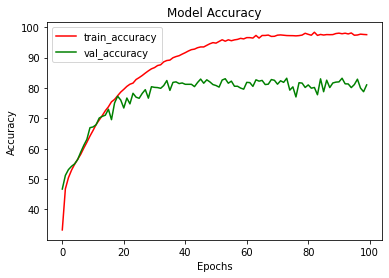

total time taken 4390.100716590881


In [ ]:
epochs=np.arange(0,100,1)  
y=train_accuracies
z=val_accuracies
# Plotting both the curves simultaneously
plt.plot(epochs, y, color='r', label='train_accuracy')
plt.plot(epochs, z, color='g', label='val_accuracy')
  
# Naming the x-axis, y-axis and the whole graph
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Model Accuracy")
  
# Adding legend, which helps us recognize the curve according to it's color
plt.legend()
  
# To load the display window
plt.show()

end=time.time()
print("total time taken",end-start)